In [ ]:
# Step 1: Install necessary packages
!pip install pycocotools pillow
!pip install opencv-python

In [ ]:
import os
import h5py
import io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# # Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File paths
hdf5_fpath = '/content/drive/MyDrive/Flowers/flowers/flowers-hd5/data/flowers/flowers.hdf5'
data_npy_path = "/content/drive/MyDrive/Flowers/data.npy"
gen_saved = "/content/drive/MyDrive/Flowers/gen_620.pth"
disc_saved = "/content/drive/MyDrive/Flowers/best_discriminator_epoch_11.pth"


Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
# !kaggle datasets download -d kmahesh541/flowershd5dataset -p "/content/drive/My Drive/flowers" --unzip

Dataset URL: https://www.kaggle.com/datasets/kmahesh541/flowershd5dataset
License(s): unknown
100% 3.46G/3.47G [01:01<00:00, 38.8MB/s]
100% 3.47G/3.47G [01:02<00:00, 60.1MB/s]


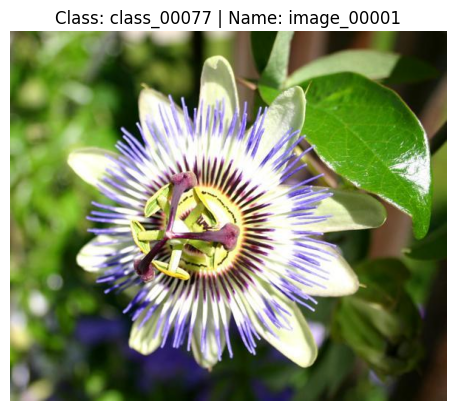

Class Label: class_00077
Embeddings (first 10 values): [ 0.10226855 -0.0868825   0.03414105 -0.02046936  0.15935501 -0.03317489
  0.03720499  0.23764007 -0.05084452  0.13234071] ...
Image Name: image_00001
Text Description: prominent purple stigma,petals are white inc olor



In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

# Path to your HDF5 file
file_path = '/content/drive/MyDrive/Flowers/flowers/flowers-hd5/data/flowers/flowers.hdf5'

# Open the HDF5 file in read mode
with h5py.File(file_path, 'r') as f:
    # Select one sample from the train group
    image_group = f['train/image_00001_0']

    # Get the class label
    class_label = image_group['class'][()].decode('utf-8')  # Decode to string if stored as bytes

    # Get the embeddings
    embeddings = np.array(image_group['embeddings'])

    # Get the name of the image
    image_name = image_group['name'][()].decode('utf-8')  # Decode to string if stored as bytes

    # Load the image data (assuming it's stored as binary data)
    img_data = image_group['img'][()]

    # Get the text description
    text_description = image_group['txt'][()].decode('utf-8')  # Decode to string if stored as bytes

    # Decode and display the image if it’s in a recognizable format (e.g., JPEG)
    try:
        image = Image.open(io.BytesIO(img_data))
        plt.imshow(image)
        plt.title(f'Class: {class_label} | Name: {image_name}')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print("Image could not be displayed:", e)

    # Print all elements
    print("Class Label:", class_label)
    print("Embeddings (first 10 values):", embeddings[:10], "...")  # Show a portion of the embeddings
    print("Image Name:", image_name)
    print("Text Description:", text_description)

In [ ]:
import h5py

# Path to your HDF5 file
file_path = '/content/drive/MyDrive/Flowers/flowers/flowers-hd5/data/flowers/flowers.hdf5'
f = h5py.File(file_path)

#1. to know the categories in hdf5 file
print(list(f))
print("\nNo. of items in test = ",len(list(f['test'])))
print("\nNo. of items in train = ",len(list(f['train'])))
print("\nNo. of items in valid = ",len(list(f['valid'])))


['test', 'train', 'valid']

No. of items in test =  5775

No. of items in train =  29390

No. of items in valid =  5780


In [ ]:
import os
import h5py
import numpy as np
from tqdm import tqdm
from PIL import Image
import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# File path for the HDF5 dataset
file_path = '/content/drive/MyDrive/Flowers/flowers/flowers-hd5/data/flowers/flowers.hdf5'

# FlowersDataset Class
class FlowersDataset(Dataset):
    def __init__(self, file_path, mode='train'):
        """
        Initializes the Flowers Dataset.
        :param file_path: Path to the HDF5 dataset.
        :param mode: 'train', 'val', or 'test' for selecting the split.
        """
        self.file_path = file_path
        self.mode = mode
        self.data = []
        self.word_to_index = {}
        self.max_sequence_length = 0

        # Check if preprocessed data exists
        preprocessed_path = f'/content/drive/MyDrive/Flowers/flowers_{mode}.npy'
        if os.path.exists(preprocessed_path):
            preprocessed_data = np.load(preprocessed_path, allow_pickle=True).item()
            self.data = preprocessed_data['data']
            self.word_to_index = preprocessed_data['word_to_index']
            self.max_sequence_length = preprocessed_data['max_sequence_length']
        else:
            self._process_dataset()
            # Save preprocessed data for faster subsequent loading
            np.save(preprocessed_path, {
                'data': self.data,
                'word_to_index': self.word_to_index,
                'max_sequence_length': self.max_sequence_length
            })

        # Transformations for the image
        self.transforms = transforms.ToTensor()

    def _process_dataset(self):
        """
        Processes the raw HDF5 dataset, tokenizes the text, and stores data in memory.
        """
        with h5py.File(self.file_path, 'r') as f:
            dataset = f[self.mode]
            unique_texts = set()

            for img_name in tqdm(dataset):
                # Load image
                image_bytes = bytes(np.array(dataset[img_name]['img']))
                image = np.array(Image.open(io.BytesIO(image_bytes)).resize((256, 256)))

                # Load and process text
                text = dataset[img_name]['txt'][()].decode('utf-8').strip()
                if text not in unique_texts:
                    unique_texts.add(text)
                    words = text.split()
                    self.max_sequence_length = max(self.max_sequence_length, len(words))

                    # Build word-to-index dictionary
                    tokenized_text = []
                    for word in words:
                        if word not in self.word_to_index:
                            self.word_to_index[word] = len(self.word_to_index) + 1
                        tokenized_text.append(self.word_to_index[word])

                    self.data.append({
                        'image': image,
                        'text': tokenized_text
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a sample consisting of the image, mismatched image, correct text, and mismatched text.
        """
        data_item = self.data[idx]
        image = self.transforms(Image.fromarray(data_item['image']))
        right_text = np.array([0] * (self.max_sequence_length - len(data_item['text'])) + data_item['text'])

        # Randomly select a mismatched sample
        wrong_idx = np.random.choice([i for i in range(len(self.data)) if i != idx])
        wrong_item = self.data[wrong_idx]
        wrong_image = self.transforms(Image.fromarray(wrong_item['image']))
        wrong_text = np.array([0] * (self.max_sequence_length - len(wrong_item['text'])) + wrong_item['text'])

        return image, wrong_image, right_text, wrong_text




In [ ]:
# Instantiate and Load Dataset
train_dataset = FlowersDataset(file_path, mode='train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Example Usage
for batch in train_loader:
    images, wrong_images, right_texts, wrong_texts = batch
    print(f"Images: {images.shape}, Wrong Images: {wrong_images.shape}")
    print(f"Right Texts: {right_texts.shape}, Wrong Texts: {wrong_texts.shape}")
    break

Images: torch.Size([8, 3, 256, 256]), Wrong Images: torch.Size([8, 3, 256, 256])
Right Texts: torch.Size([8, 65]), Wrong Texts: torch.Size([8, 65])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os


# Text Encoder
class TextEncoder(nn.Module):
    def __init__(self, voc_size, embed_size=128, hidden_size=256, n_layers=1, bidirectional=True, use_attention=True):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.use_attention = use_attention
        self.embedding = nn.Embedding(voc_size, embed_size, padding_idx=0)
        self.gru = nn.GRU(embed_size, hidden_size, n_layers, bidirectional=True, batch_first=True)
        if self.use_attention:
            self.W1 = nn.Linear(hidden_size, hidden_size)
            self.W2 = nn.Linear(hidden_size, hidden_size)
            self.V = nn.Linear(hidden_size, 1)

    def attention(self, enc_outputs, hidden):
        # score: batch_size, max_length, hidden_dim
        score = torch.tanh(self.W1(enc_outputs)+self.W2(hidden))
        # attention_weights: batch_size, max_length, 1
        # we get 1 at the last axis because we are applying score to self.V
        attn_weights = torch.softmax(self.V(score), dim=1)
        # context_vector shape after sum == (batch_size, hidden_dim)
        context_vector = torch.sum(attn_weights*enc_outputs, dim=1)
        return context_vector

    def forward(self,input_seqs, hidden=None):
        input_lens = input_seqs.ne(0).sum(dim=1).cpu()
        input_lens, sort_idx = input_lens.sort(dim=0, descending=True)
        input_seqs = input_seqs[sort_idx]
        embedded = self.embedding(input_seqs)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lens,  batch_first=True)
        outputs, hidden = self.gru(packed,hidden)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        _, unsort_idx = sort_idx.sort(dim=0)
        outputs = outputs[unsort_idx].contiguous()
        outputs = outputs[..., :self.hidden_size] + outputs[..., self.hidden_size:]
        hidden = hidden.sum(dim=0).unsqueeze(dim=1)
        context_vector = self.attention(outputs, hidden) if self.use_attention else hidden
        return context_vector.view(-1, self.hidden_size, 1, 1)


# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(Generator, self).__init__()

        # Projection for text embeddings
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, 128),  # Match projection.0.weight
            nn.BatchNorm1d(128),           # Match projection.1.*
            nn.ReLU()
        )

        # Main generator network
        self.netG = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + 128, 512, 4, 1, 0, bias=False),  # Match netG.0.weight
            nn.BatchNorm2d(512),                                           # Match netG.1.*
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),             # Match netG.3.weight
            nn.BatchNorm2d(256),                                           # Match netG.4.*
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),             # Match netG.6.weight
            nn.BatchNorm2d(128),                                           # Match netG.7.*
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),              # Match netG.9.weight
            nn.BatchNorm2d(64),                                            # Match netG.10.*
            nn.ReLU(True),
            nn.ConvTranspose2d(64, image_channels, 4, 2, 1, bias=False),   # Match netG.12.weight
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, noise, text_embedding):
        # Project text embedding
        text_embedding = self.projection(text_embedding)
        text_embedding = text_embedding.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions
        # Combine noise and projected text embedding
        combined_input = torch.cat((noise, text_embedding), dim=1)
        # Generate image
        return self.netG(combined_input)



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7,7), padding=(3,3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        self.layer2 =  nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3,3),padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3),padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        self.layer3 =  nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,3),padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3,3),padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(512, 256),
            nn.Linear(256, 1),  # Change output size to 1
            nn.Sigmoid()  # Apply Sigmoid to get probabilities
        )

    def forward(self, x, encoded_text):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.cat([x, encoded_text], dim=1)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [1]:
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = Generator(noise_dim=100, embedding_dim=128).to(device)
disc = Discriminator().to(device)
text_enc = TextEncoder(voc_size=len(train_dataset.word_to_index) + 1).to(device)

# Load the saved states
saved_models = torch.load(gen_saved, map_location=device)

gen.load_state_dict(saved_models)

saved_discriminator = torch.load(disc_saved, map_location=device)
disc.load_state_dict(saved_discriminator)

# Optimizers
optimizer_G = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_T = optim.Adam(text_enc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Paths for saving best models
base_path = "/content/drive/MyDrive/Flowers"

# Initialize variables for best models
best_loss_G = float('inf')
best_loss_D = float('inf')


# Training loop
def Train(epoch):
    global best_loss_G, best_loss_D

    total_loss_G = 0
    total_loss_D = 0

    for right_img, wrong_img, right_text, wrong_text in train_loader:
        torch.cuda.empty_cache()
        right_img = right_img.to(device)
        wrong_img = wrong_img.to(device)
        right_text = right_text.to(device)
        wrong_text = wrong_text.to(device)

        # Encode text
        Enc_right_text = text_enc(right_text)
        Enc_wrong_text = text_enc(wrong_text)

        # Labels for discriminator
        ones = torch.ones((right_img.shape[0], 1), device=device)
        zeros = torch.zeros((right_img.shape[0], 1), device=device)
        noise = torch.randn((len(right_img), 100, 1, 1), device=device)

        # Generate fake images
        fake_img = gen(noise, Enc_right_text.detach())

        # Discriminator forward pass
        D_right = disc(right_img, Enc_right_text)
        D_wrong_text = disc(right_img, Enc_wrong_text)
        D_wrong_img = disc(wrong_img, Enc_right_text)
        D_fake = disc(fake_img.detach(), Enc_right_text.detach())

        # Compute discriminator losses
        loss_D_right = criterion(D_right, ones)
        loss_D_wrong_text = criterion(D_wrong_text, zeros)
        loss_D_fake = criterion(D_fake, zeros)
        loss_D_wrong_img = criterion(D_wrong_img, zeros)

        loss_D = loss_D_right + 0.25 * loss_D_wrong_text + 0.25 * loss_D_wrong_img + 0.5 * loss_D_fake

        # Update discriminator
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Generator forward pass
        D_fake = disc(fake_img, Enc_right_text.detach())
        loss_G = criterion(D_fake, ones)

        # Update generator
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Accumulate losses
        total_loss_G += loss_G.item()
        total_loss_D += loss_D.item()

    avg_loss_G = total_loss_G / len(train_loader)
    avg_loss_D = total_loss_D / len(train_loader)
    print(f"Epoch {epoch}, Loss_D: {avg_loss_D}, Loss_G: {avg_loss_G}")

    # Save the best generator
    if avg_loss_G < best_loss_G:
        best_loss_G = avg_loss_G
        gen_save_path = os.path.join(base_path, f"best_gen_epoch_{epoch}.pth")
        torch.save(gen.state_dict(), gen_save_path)
        print(f"Best Generator saved at: {gen_save_path} with Loss_G: {best_loss_G}")

    # Save the best discriminator
    if avg_loss_D < best_loss_D:
        best_loss_D = avg_loss_D
        disc_save_path = os.path.join(base_path, f"best_disc_epoch_{epoch}.pth")
        torch.save(disc.state_dict(), disc_save_path)
        print(f"Best Discriminator saved at: {disc_save_path} with Loss_D: {best_loss_D}")

    # Save the best overall model
    best_model_save_path = os.path.join(base_path, f"best_model_epoch_{epoch}.pth")
    best_model_details = {
        "text_encoder": text_enc.state_dict(),
        "discriminator": disc.state_dict(),
        "generator": gen.state_dict(),
        "optimizer_D": optimizer_D.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_T_E": optimizer_T.state_dict(),
        "word_to_index": train_dataset.word_to_index,
        "max_sequence_length": train_dataset.max_sequence_length,
    }
    torch.save(best_model_details, best_model_save_path)
    print(f"Best Model saved at: {best_model_save_path}")

    return avg_loss_D, avg_loss_G

# Initialize loss history
loss_d_hist = []
loss_g_hist = []

# Run training loop
epochs = 15
for i in range(epochs):
    loss_D, loss_G = Train(i + 1)
    loss_d_hist.append(loss_D)
    loss_g_hist.append(loss_G)

print("Training complete. Models saved.")


Epoch 1, Loss_D: 1.210819827040305, Loss_G: 2.609431615673207
Best generator saved for epoch 1 with loss 2.6509431615673207
Best discriminator saved for epoch 1 with loss 1.210819827040305
Full model saved for epoch 1
Epoch 2, Loss_D: 1.1564985381540012, Loss_G: 6.1790851132340125
Best discriminator saved for epoch 2 with loss 1.1564985381540012
Full model saved for epoch 2
Epoch 3, Loss_D: 1.0792348450553175, Loss_G: 6.057931160352923
Best discriminator saved for epoch 3 with loss 1.0792348450553175
Full model saved for epoch 3
Epoch 4, Loss_D: 1.0645111495175876, Loss_G: 7.2016776464376093
Best discriminator saved for epoch 4 with loss 1.0645111495175876
Full model saved for epoch 4
Epoch 5, Loss_D: 1.0648669759063303, Loss_G: 5.2847475485775517
Full model saved for epoch 5
Epoch 6, Loss_D: 1.036469789775642, Loss_G: 8.882148727522911
Best discriminator saved for epoch 6 with loss 1.036469789775642
Full model saved for epoch 6
Epoch 7, Loss_D: 1.0552635610959418, Loss_G: 3.7098680595

<ipython-input-53-8d1888bbcc71>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(full_model_path)


Generating image for: A vibrant red rose with green leaves


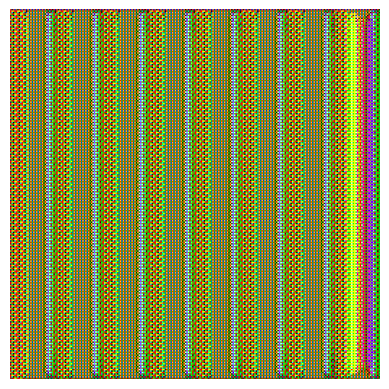

Generating image for: A yellow sunflower under a bright sky


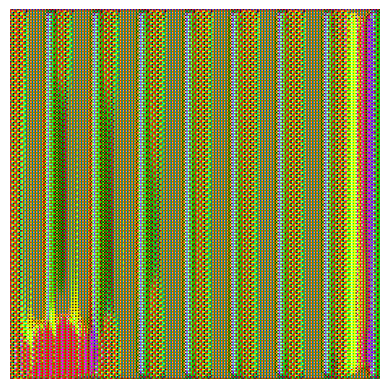

Generating image for: A pink tulip with delicate petals


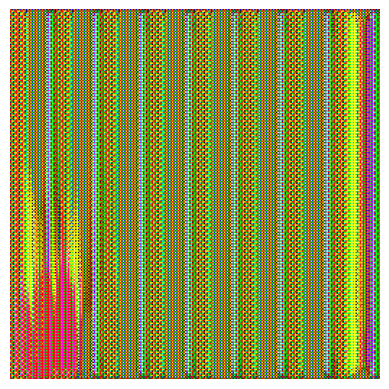

In [ ]:
import torch
import matplotlib.pyplot as plt

# Path to the full model saved at epoch 11
epoch_to_load = 15
base_path = "/content/drive/MyDrive/Flowers/"
full_model_path = f"{base_path}full_model_epoch_{epoch_to_load}.pth"

# Load the full model file
checkpoint = torch.load(full_model_path)

# Restore model states
text_enc.load_state_dict(checkpoint["text_encoder"])
gen.load_state_dict(checkpoint["generator"])

# Set models to evaluation mode
text_enc.eval()
gen.eval()

import torch
import matplotlib.pyplot as plt

# Function to display generated images
def display_image(image_tensor):
    """Convert a tensor to an image and display it."""
    image = image_tensor.cpu().detach().numpy().transpose(1, 2, 0)  # Convert to HWC format
    image = (image + 1) / 2  # Normalize from [-1, 1] to [0, 1]
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Function to generate an image from text
def generate_image_from_text(generator, text_encoder, text, word_to_index, max_sequence_length, device="cuda"):
    generator.to(device)
    text_encoder.to(device)

    # Convert text to encoded input
    encoded_text_input = torch.zeros((1, max_sequence_length), dtype=torch.long).to(device)
    words = text.lower().split()
    for i, word in enumerate(words[:max_sequence_length]):
        encoded_text_input[0, i] = word_to_index.get(word, word_to_index.get("<unk>", 0))

    # Encode the text
    with torch.no_grad():
        encoded_text = text_encoder(encoded_text_input)  # Output shape: [1, 256, 1, 1]

    # Generate random noise
    noise_dim = 100  # Adjust this to match the generator's expected noise dimension
    noise = torch.randn((1, noise_dim, 1, 1)).to(device)

    # Generate an image
    with torch.no_grad():
        generated_image = generator(noise, encoded_text)  # Output shape: [1, 3, H, W]

    # Display the generated image
    display_image(generated_image[0])

# Example text descriptions
text_descriptions = [
    "A vibrant red rose with green leaves",
    "A yellow sunflower under a bright sky",
    "A pink tulip with delicate petals",
]

# Generate and display images for each text description
device = "cuda" if torch.cuda.is_available() else "cpu"
for description in text_descriptions:
    print(f"Generating image for: {description}")
    generate_image_from_text(gen, text_enc, description, checkpoint["word_to_index"], checkpoint["max_sequence_length"], device=device)

In [ ]:
# Paths for saving models
base_path = "/content/drive/MyDrive/Flowers/"

# Track best losses
best_loss_G = float('inf')
best_loss_D = float('inf')

# Loss histories
loss_d_hist = []
loss_g_hist = []

for epoch in range(15):  # Train for 15 epochs
    loss_D, loss_G = Train(epoch + 1)
    loss_d_hist.append(loss_D)
    loss_g_hist.append(loss_G)

    # Save the best generator model
    generator_path = f"{base_path}best_generator_epoch_{epoch+1}.pth"
    if loss_G < best_loss_G:
        best_loss_G = loss_G
        torch.save(gen.state_dict(), generator_path)
        print(f"Best generator saved for epoch {epoch+1} with loss {best_loss_G}")

    # Save the best discriminator model
    discriminator_path = f"{base_path}best_discriminator_epoch_{epoch+1}.pth"
    if loss_D < best_loss_D:
        best_loss_D = loss_D
        torch.save(disc.state_dict(), discriminator_path)
        print(f"Best discriminator saved for epoch {epoch+1} with loss {best_loss_D}")

    # Save the full model with all components for resuming training
    full_model_path = f"{base_path}full_model_epoch_{epoch+1}.pth"
    saved_model_with_all = {
        "text_encoder": text_enc.state_dict(),
        "discriminator": disc.state_dict(),
        "generator": gen.state_dict(),
        "optimizer_D": optimizer_D.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_T_E": optimizer_T.state_dict(),
        "word_to_index": train_dataset.word_to_index,
        "max_sequence_length": train_dataset.max_sequence_length,
        "loss_d_hist": loss_d_hist,
        "loss_g_hist": loss_g_hist,
        "epoch": epoch + 1
    }
    torch.save(saved_model_with_all, full_model_path)
    print(f"Full model saved for epoch {epoch+1}")

print("Training complete. Models saved.")

Epoch 1, Loss_D: 1.210819827040305, Loss_G: 1.6509431615673207
Best generator saved for epoch 1 with loss 1.6509431615673207
Best discriminator saved for epoch 1 with loss 1.210819827040305
Full model saved for epoch 1
Epoch 2, Loss_D: 1.1564985381540012, Loss_G: 2.1790851132340125
Best discriminator saved for epoch 2 with loss 1.1564985381540012
Full model saved for epoch 2
Epoch 3, Loss_D: 1.0792348450553175, Loss_G: 3.057931160352923
Best discriminator saved for epoch 3 with loss 1.0792348450553175
Full model saved for epoch 3
Epoch 4, Loss_D: 1.0645111495175876, Loss_G: 3.2016776464376093
Best discriminator saved for epoch 4 with loss 1.0645111495175876
Full model saved for epoch 4
Epoch 5, Loss_D: 1.0648669759063303, Loss_G: 3.2847475485775517
Full model saved for epoch 5
Epoch 6, Loss_D: 1.036469789775642, Loss_G: 3.882148727522911
Best discriminator saved for epoch 6 with loss 1.036469789775642
Full model saved for epoch 6
Epoch 7, Loss_D: 1.0552635610959418, Loss_G: 3.709868059

In [ ]:
print(gen.forward.__doc__)

None


In [ ]:
import os
import h5py
import io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# # Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File paths
hdf5_fpath = '/content/drive/MyDrive/Flowers/flowers/flowers-hd5/data/flowers/flowers.hdf5'
data_npy_path = "/content/drive/MyDrive/Flowers/data.npy"
gen_saved = "/content/drive/MyDrive/Flowers/gen_620.pth"
disc_saved = "/content/drive/MyDrive/Flowers/best_discriminator_epoch_11.pth"


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-9-560bf657fe2d>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(gen_saved, map_location=device))


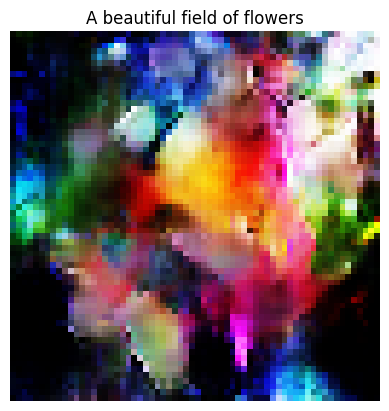

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from torchvision import transforms
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Path to the pretrained generator
gen_saved = "/content/drive/MyDrive/Flowers/best_generator_epoch_1.pth"

# Define your generator class
class FlowerGenerator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(FlowerGenerator, self).__init__()

        # Projection for text embeddings
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        # Main generator network
        self.netG = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + 128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, noise, text_embedding):
        # Project text embedding
        text_embedding = self.projection(text_embedding)
        text_embedding = text_embedding.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions
        # Combine noise and projected text embedding
        combined_input = torch.cat((noise, text_embedding), dim=1)
        # Generate image
        return self.netG(combined_input)

# Load the generator model
noise_dim = 100
embedding_dim = 1024  # Match the pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = FlowerGenerator(noise_dim, embedding_dim).to(device)
generator.load_state_dict(torch.load(gen_saved, map_location=device))
generator.eval()

# Text-to-Embedding Function
def text_to_embedding(prompt, embedding_dim=1024):
    # Placeholder: Replace with actual text embedding model if available
    torch.manual_seed(len(prompt))  # Make it deterministic based on prompt
    return torch.randn(1, embedding_dim).to(device)

# Generate Image Function
def generate_image(prompt, latent_dim=100, image_size=(128, 128)):
    noise = torch.randn(1, latent_dim, 1, 1).to(device)  # Latent noise vector
    text_embedding = text_to_embedding(prompt, embedding_dim)
    with torch.no_grad():
        generated_image = generator(noise, text_embedding)

    # Convert the output to an image
    generated_image = generated_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    generated_image = (generated_image + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
    generated_image = np.clip(generated_image, 0, 1) * 255  # Scale to [0, 255]
    return generated_image.astype(np.uint8)

# Test the generator with a sample prompt
prompt = "A beautiful field of flowers"
generated_img = generate_image(prompt)

# Display the generated image using matplotlib
plt.imshow(generated_img)
plt.axis('off')  # Turn off axes for better visualization
plt.title(prompt)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-c7fdf30587f2>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(gen_saved, map_location=device))


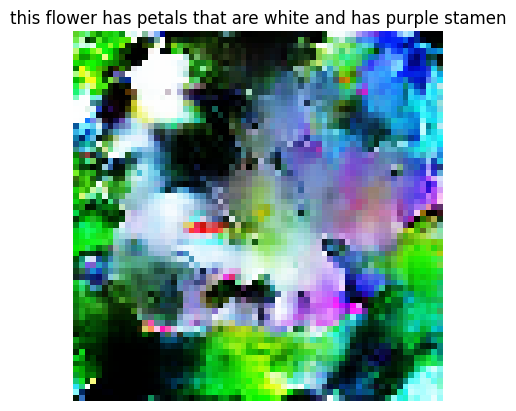

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from torchvision import transforms
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Path to the pretrained generator
gen_saved = "/content/drive/MyDrive/Flowers/best_generator_epoch_1.pth"

# Define your generator class
class FlowerGenerator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(FlowerGenerator, self).__init__()

        # Projection for text embeddings
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        # Main generator network
        self.netG = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + 128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, noise, text_embedding):
        # Project text embedding
        text_embedding = self.projection(text_embedding)
        text_embedding = text_embedding.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions
        # Combine noise and projected text embedding
        combined_input = torch.cat((noise, text_embedding), dim=1)
        # Generate image
        return self.netG(combined_input)

# Load the generator model
noise_dim = 100
embedding_dim = 1024  # Match the pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = FlowerGenerator(noise_dim, embedding_dim).to(device)
generator.load_state_dict(torch.load(gen_saved, map_location=device))
generator.eval()

# Text-to-Embedding Function
def text_to_embedding(prompt, embedding_dim=1024):
    # Placeholder: Replace with actual text embedding model if available
    torch.manual_seed(len(prompt))  # Make it deterministic based on prompt
    return torch.randn(1, embedding_dim).to(device)

# Generate Image Function
def generate_image(prompt, latent_dim=100, image_size=(128, 128)):
    noise = torch.randn(1, latent_dim, 1, 1).to(device)  # Latent noise vector
    text_embedding = text_to_embedding(prompt, embedding_dim)
    with torch.no_grad():
        generated_image = generator(noise, text_embedding)

    # Convert the output to an image
    generated_image = generated_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    generated_image = (generated_image + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
    generated_image = np.clip(generated_image, 0, 1) * 255  # Scale to [0, 255]
    return generated_image.astype(np.uint8)

# Test the generator with a sample prompt
prompt = "this flower has petals that are white and has purple stamen"
generated_img = generate_image(prompt)

# Display the generated image using matplotlib
plt.imshow(generated_img)
plt.axis('off')  # Turn off axes for better visualization
plt.title(prompt)
plt.show()